In [14]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  %cd /content/drive/MyDrive/M5_Project/Week4
  !ls

In [15]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim

from PIL import Image
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset  # For custom datasets

from trainer import fit
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Prepare Dataset

In [16]:
TRAIN_DATA_PATH = "../MIT_split/train/"
TEST_DATA_PATH = "../MIT_split/test/"

batch_size = 128

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 8

In [17]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64


# Plot Embedding

In [18]:
mit_classes = ['coast', 'forest', 'highway', 'inside_city', 'mountain',
                         'Opencountry', 'street', 'tallbuilding']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mit_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline

In [19]:
# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet_v2
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet_v2(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
    print('Cuda!!!')
loss_fn = torch.nn.NLLLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.96)
n_epochs = 25
log_interval = 100

Cuda!!!


In [20]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/group05/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 2.087414	Accuracy: 14.84375
Epoch: 1/25. Train set: Average loss: 2.6384	Accuracy: 14.088250930356194
Epoch: 1/25. Validation set: Average loss: 2.1884	Accuracy: 15.737298636926889
Train: [0/1881 (0%)]	Loss: 2.217535	Accuracy: 14.84375
Epoch: 2/25. Train set: Average loss: 2.1831	Accuracy: 16.321105794790004
Epoch: 2/25. Validation set: Average loss: 1.9563	Accuracy: 24.411400247831473
Train: [0/1881 (0%)]	Loss: 1.934162	Accuracy: 21.875
Epoch: 3/25. Train set: Average loss: 1.8969	Accuracy: 25.677830940988837
Epoch: 3/25. Validation set: Average loss: 1.8385	Accuracy: 24.65923172242875
Train: [0/1881 (0%)]	Loss: 1.918039	Accuracy: 23.4375
Epoch: 4/25. Train set: Average loss: 1.7854	Accuracy: 26.687931951089844
Epoch: 4/25. Validation set: Average loss: 1.7429	Accuracy: 27.881040892193308
Train: [0/1881 (0%)]	Loss: 1.709885	Accuracy: 31.25
Epoch: 5/25. Train set: Average loss: 1.7114	Accuracy: 30.83466241360978
Epoch: 5/25. Validation set: Average loss: 1.71

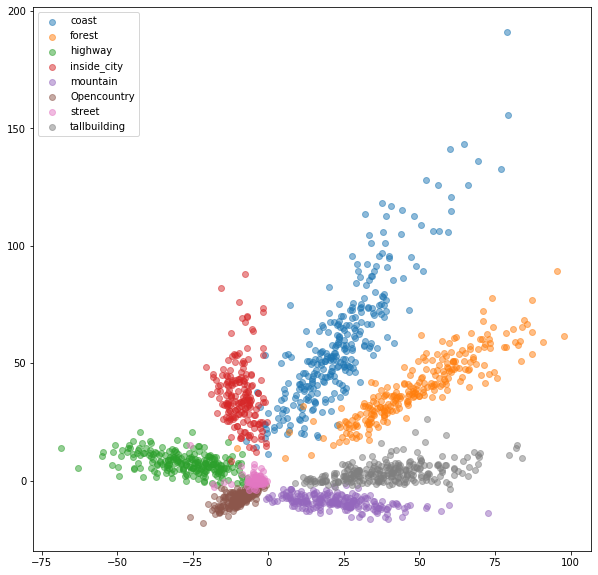

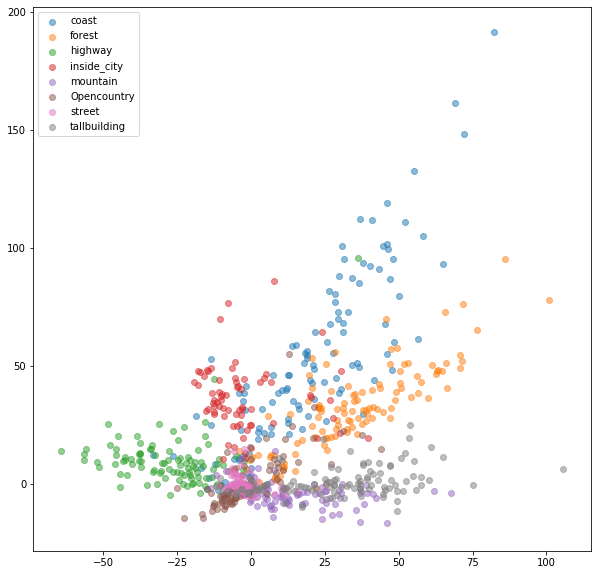

In [21]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# SiameseNet

## Custum Dataset Class for MIT split

In [47]:
class MITSplitDataset(Dataset):
    def __init__(self,train_path,test_path, transform, train):
        # Transforms
        self.transform=transform
        self.train=train
        self.to_tensor = transforms.ToTensor()

        # Read the csv file
        if self.train:
            self.train_data_info = pd.read_csv(train_path,header=None)
            self.train_data =[] 
            
            print("printing train data length MIT Split")
            print(len(self.train_data_info.index))

            for (i,j) in enumerate(np.asarray(self.train_data_info.iloc[:, 1])):
                try :
                    self.train_data.append(self.to_tensor(Image.open(j)))
                except : 
                    print('ERROR LOADING:' + j)
            
            self.train_data = torch.stack(self.train_data)
            
            self.train_labels = np.asarray(self.train_data_info.iloc[:, 2])
            self.train_labels = torch.from_numpy(self.train_labels)
            self.train_data_len = len(self.train_data_info.index)

        else :
            self.test_data_info = pd.read_csv(test_path,header=None)
            self.test_data =[] 
            for (i,j) in enumerate(np.asarray(self.test_data_info.iloc[:, 1])):
                try : 
                    self.test_data.append(self.to_tensor(Image.open(j)))
                except : 
                    print('ERROR LOADING:' + j) 

            self.test_data = torch.stack(self.test_data)
            self.test_labels = np.asarray(self.test_data_info.iloc[:, 2])
            self.test_labels = torch.from_numpy(self.test_labels)
            
            self.test_data_len = len(self.test_data_info.index)
            

    def __getitem__(self, index):
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        return (img,target)

    def __len__(self):
        if self.train :
            return self.train_data_len
        else :
            return self.test_data_len

# Set up

In [48]:
from datasets import SiameseMNIST

cuda = torch.cuda.is_available()

TRAIN_DATA_PATH = "../MIT_split/train_data.csv"
TEST_DATA_PATH = "../MIT_split/test_data.csv"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(64),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

TRANSFORM_IMG_TEST = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

## Training !

In [49]:
# Setup datasets for training
train_data = MITSplitDataset(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

siamese_train_dataset = SiameseMNIST(train_data) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_data)

batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.9, last_epoch=-1)
n_epochs = 20
log_interval = 500

printing train data length MIT Split
1881


In [50]:
## Visualise input
for X, y in siamese_test_loader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 64, 5461])
Shape of y: torch.Size([128]) torch.int64


In [7]:
## Training !!!
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/group05/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/group05/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/group05/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/group05/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/export/home/group05/MCV-2022-M5-Project/Week4/datasets.py", line 137, in __getitem__
    img1 = Image.fromarray(img1.numpy(), mode='RGB')
  File "/home/group05/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2825, in fromarray
    raise ValueError(f"Too many dimensions: {ndim} > {ndmax}.")
ValueError: Too many dimensions: 3 > 2.


In [19]:
## Plot embedding
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x238144 and 1133184x256)

# TripletNet

In [51]:
class MITSplitDataset_Triplet(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label.item(): np.where(np.asarray(self.train_labels) == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels)
                        
            self.label_to_indices = {label.item(): np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            # print(self.label_to_indices)

            triplets = []
            for i in range(len(self.test_data)):
                    triplets.append([i,
                                random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                                random_state.choice(self.label_to_indices[
                                                        np.random.choice(
                                                            list(self.labels_set - set([self.test_labels[i].item()]))
                                                        )
                                                    ])
                                ])
            self.test_triplets = triplets

    def get_type(self):
        print("test_labels type"+str(type(self.test_labels)))
    
    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='RGB')
        img2 = Image.fromarray(img2.numpy(), mode='RGB')
        img3 = Image.fromarray(img3.numpy(), mode='RGB')

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

In [52]:
from datasets import TripletDataset

train_data = MITSplitDataset(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

triplet_train_dataset = MITSplitDataset_Triplet(train_data) # Returns triplet of images and target same/different
triplet_test_dataset = MITSplitDataset_Triplet(test_data)

batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.9, last_epoch=-1)
n_epochs = 20
log_interval = 500

printing train data length MIT Split
1881


In [53]:
## Visualise input
for X, y in siamese_test_loader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 64, 5461])
Shape of y: torch.Size([128]) torch.int64


## Balanced Batch Sampler

In [ ]:
# Set up data loaders
from datasets import BalancedBatchSampler
import numpy as np

# train_labels = np.array(train_data.targets, dtype=np.float32)
# test_labels = np.array(test_data.targets, dtype=np.float32)

# Step 1
train_batchSampler = BalancedBatchSampler(train_data.targets, n_classes=n_classes, n_samples=n_classes)
test_batchSampler = BalancedBatchSampler(test_data.targets, n_classes=n_classes, n_samples=n_classes)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = DataLoader(train_data, batch_sampler=train_batchSampler, **kwargs)
siamese_test_loader = DataLoader(test_data, batch_sampler=test_batchSampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.96)
# scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 30
log_interval = 500

In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


TypeError: ignored

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)